In [92]:
# Insert below the path of the developer version of pyBBarolo (= the git repo)
# This way, we can override any other installed version and 
# modify pyBBarolo without the need of reinstalling it every time
import sys
sys.path.insert(0, "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7")

# i just copied the repository

# This should give version 1.3.2dev!
from pyBBarolo import version
print (version)
import pyBBarolo as BB
import pyBBarolo.utils as ut
from pyBBarolo.bayesian import BayesianBBarolo

from dynesty import plotting as dyplot
from astropy.table import Table 
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import os, subprocess
from astropy.io import fits
BBmain = "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/BBarolo"


1.3.2dev


model 4 has constant vdisp and model 3 has the linear thing

In [93]:
# Name of the FITS file to be fitted
fitsname = "/Users/blanca/Documents/TESIS/software/code/models/model3.fits"
ringfile = "/Users/blanca/Documents/TESIS/software/code/models/model3_params.txt"
outputfile = "/Users/blanca/Documents/TESIS/software/code/inc_test/vdisp_lin_360_incfree/"

## Fitting:

In [94]:
# f = BB.Search._compute(fitsname) i think this might do something formy problem 

# Creating an object for bayesian barolo
f3d = BayesianBBarolo(fitsname)
th  = multiprocessing.cpu_count() #this counts my cpu so that the code can run with all of them

# Initializing rings. All parameters should be given.
# No-fitted parameters will be used for all models, while fitted parameters 
# are actually not even used for initial guesses.
rad = np.arange(180,1250,360)  

#I will write the initial parameters here 
xpos=36.959
ypos=38.199
vsys=0.0
vrad=0
z0=0
inc=50.988
phi=124.147

f3d.init(radii=rad,xpos=xpos,ypos=ypos,vsys=vsys,\
         vrot=120,vdisp=8,vrad=vrad,z0=z0,inc=inc,phi=phi)
# so basically if all the parameters are free the initial guesses are irrelevant?

# Here it is possible to give any other BBarolo parameter, for example to control
# the mask, linear, bweight, cdens, wfunc, etc...
f3d.set_options(mask="SEARCH",linear=0.85)
f3d.show_options()

# Default priors are uniform and the default boundaries for the fit are in f3d.bounds. ****
# Here I modify some of them to help convergence for this particular galaxy. --> adapt for every cube!!

#THESE ARE THE BOUNDS ENRICO USED: so the bounds for model 1
#f3d.bounds['vrot']  = [0,250]
#f3d.bounds['vdisp'] = [0,40]
#f3d.bounds['inc']   = [50,70]
#f3d.bounds['phi']   = [20,40]
#f3d.bounds['z0']    = [0,60]
#f3d.bounds['xpos']  = [20,30]
#f3d.bounds['ypos']  = [20,30]
#f3d.bounds['vsys']  = [-20,20] 

f3d.bounds['vrot']  = [0,400]
f3d.bounds['vdisp'] = [0,50]
f3d.bounds['inc']   = [0,90] #[40,60]
f3d.bounds['phi']   = [115,135] #123.7 [300,350]
#f3d.bounds['z0']    = [0,10] 
f3d.bounds['xpos']  = [30,45] #[30,45]
f3d.bounds['ypos']  = [30,45] #[30,45]
f3d.bounds['vsys']  = [110,150] 

# Running the fit with dynesty.
# To fit a parameter ring-by-ring, just use the parameter name in freepar
# To fit a parameter with a single value, add a '_single' to the parameter name
# In this example, I fit 14 parameters: 4 vrot, 4 vdisp, 1 inc, 1 pa, 1 z0, 1 xpos, 1 ypos and 1 vsys
f3d.compute(threads=th, method='dynesty',freepar=['vrot','vdisp','inc_single','phi_single','xpos_single','ypos_single','vsys_single'])
#'z0_single',

#.savefig(outputfile+'mask.pdf',bbox_inches='tight')

HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /Users/blanca/Documents/TESIS/software/code/models/model3.fits
Reading 75 x 75 x 62 pixels FITS file (1.3 MB)... Done. 

##### Input parameters for BBarolo #####
FITSFILE           /Users/blanca/Documents/TESIS/software/code/models/model3.fits 
MASK               SEARCH 
LINEAR             0.85 



15456it [35:44,  7.21it/s, batch: 8 | bound: 14 | nc: 1 | ncall: 412964 | eff(%):  3.612 | loglstar: -4.231 < -0.000 < -0.352 | logz: -9.830 +/-  0.078 | stop:  0.996]           

[230.58914793 206.04761341 125.17901819  28.87823608  19.56207456
  31.62497684  89.86902045 130.18721811  35.89123661  38.76721847
 120.95490678]


print(f3d.bounds)
with open(os.path.join(f"{outputfile}", f"bounds_used.txt"), 'w') as file:
    file.write(f"Name of the model = {modname}\n")
    file.write("\n")
    file.write("CUBE PARAMETERS\n")
    file.write("\n")
    file.write(f"Number of pixels in x/y = {xysize}\n")
    file.write(f"Size of pixels (arcsec)= {xysize}\n")
    file.write(f"Number of channels = {xysize}\n")
    file.write(f"Channel width = {chwidth}\n")
    file.write(f"Beam width = {beamFWHM}\n")
    file.write(f"RMS noise in Jy/beam = {xysize}\n")
    file.write(f"crvals = {crvals}\n")
    file.write(f"crpixs = {crpixs}\n")
    file.write("\n")
    file.write("GALAXY PARAMETERS\n")

## Model of resulting parameters:

In [95]:
print(f3d.freepar_idx)
#print(f3d.freepar_names)
print(f3d.ndim)


#we calculate the parameters of the initial mock
# Open the FITS file
hdul = fits.open(fitsname)
modname   = 'barbamodel' #this is the name of the model
# Get the header of the primary HDU (Header Data Unit)
fi = hdul[0].header
#these are the sizes
xaxis = fi['NAXIS1']
yaxis = fi['NAXIS2']
zaxis = fi['NAXIS3']
xaxis = fi['NAXIS1']
#here the cdelts
pix1 = np.abs(fi['CDELT1']) #check if this works!
pix2 = fi['CDELT2']
chan = fi['CDELT3']
# the beam
bea = fi['BMAJ']

#creating the shape of the model
sim = ut.SimulatedGalaxyCube(axisDim=[xaxis, yaxis, zaxis],\
                        cdelts=[pix1, pix2, chan],\
                        beam=bea, bunit='JY/BEAM', obj=modname)


#we set the parameters
vel  = f3d.params[f3d.freepar_idx["vrot"]]

disp = f3d.params[f3d.freepar_idx["vdisp"]]

if "inc" in f3d.freepar_idx:
    inc  = np.full(len(rad),f3d.params[f3d.freepar_idx["inc"]])
else:
    inc = np.full(len(rad), inc)   

if "phi" in f3d.freepar_idx:
    phi  =  np.full(len(rad),f3d.params[f3d.freepar_idx["phi"]])
else:
    phi = np.full(len(rad), phi)    

z0d   = np.full(len(rad),0.000)

if "xpos" in f3d.freepar_idx:
    xpos  = np.full(len(rad),f3d.params[f3d.freepar_idx["xpos"]])
else:
    xpos = np.full(len(rad), xpos)

if "ypos" in f3d.freepar_idx:
    ypos  = np.full(len(rad),f3d.params[f3d.freepar_idx["ypos"]])
else:
    ypos = np.full(len(rad), ypos)    
    

vsy = np.full(len(rad),f3d.params[f3d.freepar_idx["vsys"]])

dens   = np.full(len(rad),1)
#50*np.exp(-rad/400-100/(0.5*rad+100)) #I will do this for now but ideally this is in the bbarolo?
#noiserms  = 0.08 #again i need to find a way to get this number?


# Setting up galaxy parameters (if parameters are not given, they are random!)
sim.define_galaxy(radii=rad,vsys=vsy,vdisp=disp,inc=inc,pa=phi,\
                dens=dens,z0=z0d,vrot=vel,warpinc=False,warppa=False)


# Running BB and creating a model
print (f"Simulating {modname}...",flush=True,end='')
sim.run(exe=BBmain, stdout='null', outfolder=outputfile+modname, smooth=True)



print (f"Done! ")


{'vrot': array([0, 1, 2]), 'vdisp': array([3, 4, 5]), 'inc': array([6]), 'phi': array([7]), 'xpos': array([8]), 'ypos': array([9]), 'vsys': array([10])}
11
WARNING, CDELT1 should be negative!
Simulating barbamodel...Done! 


## Dynesty outputs:

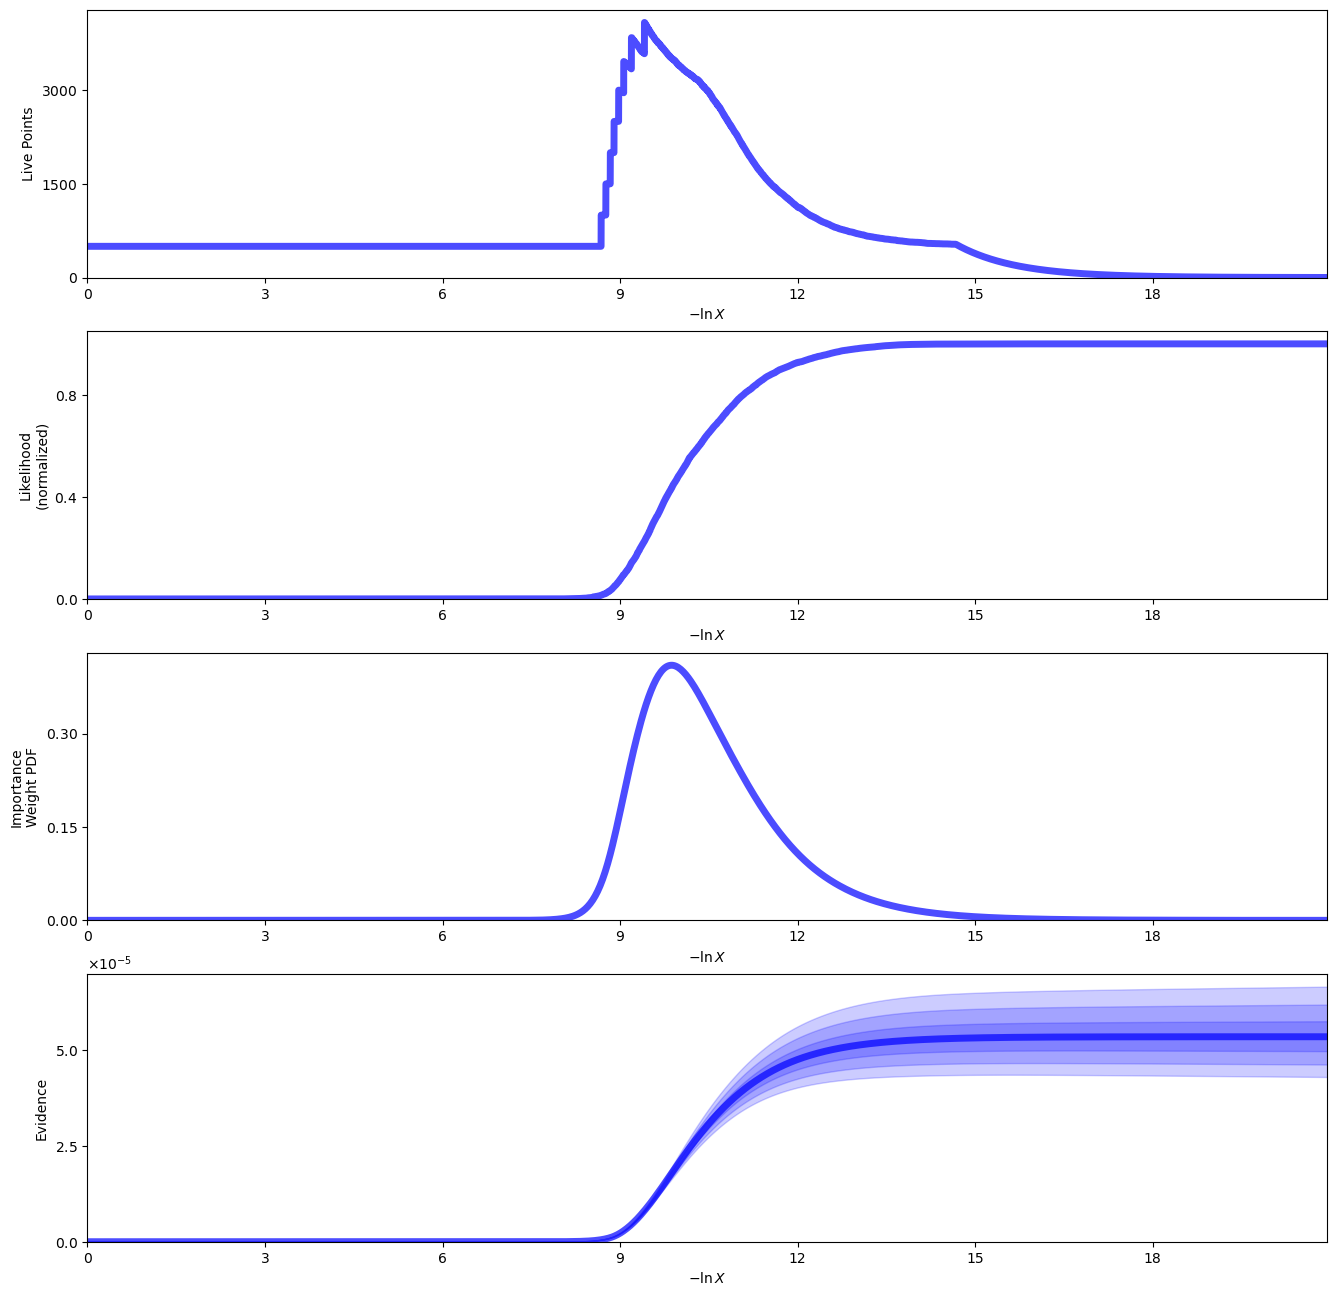

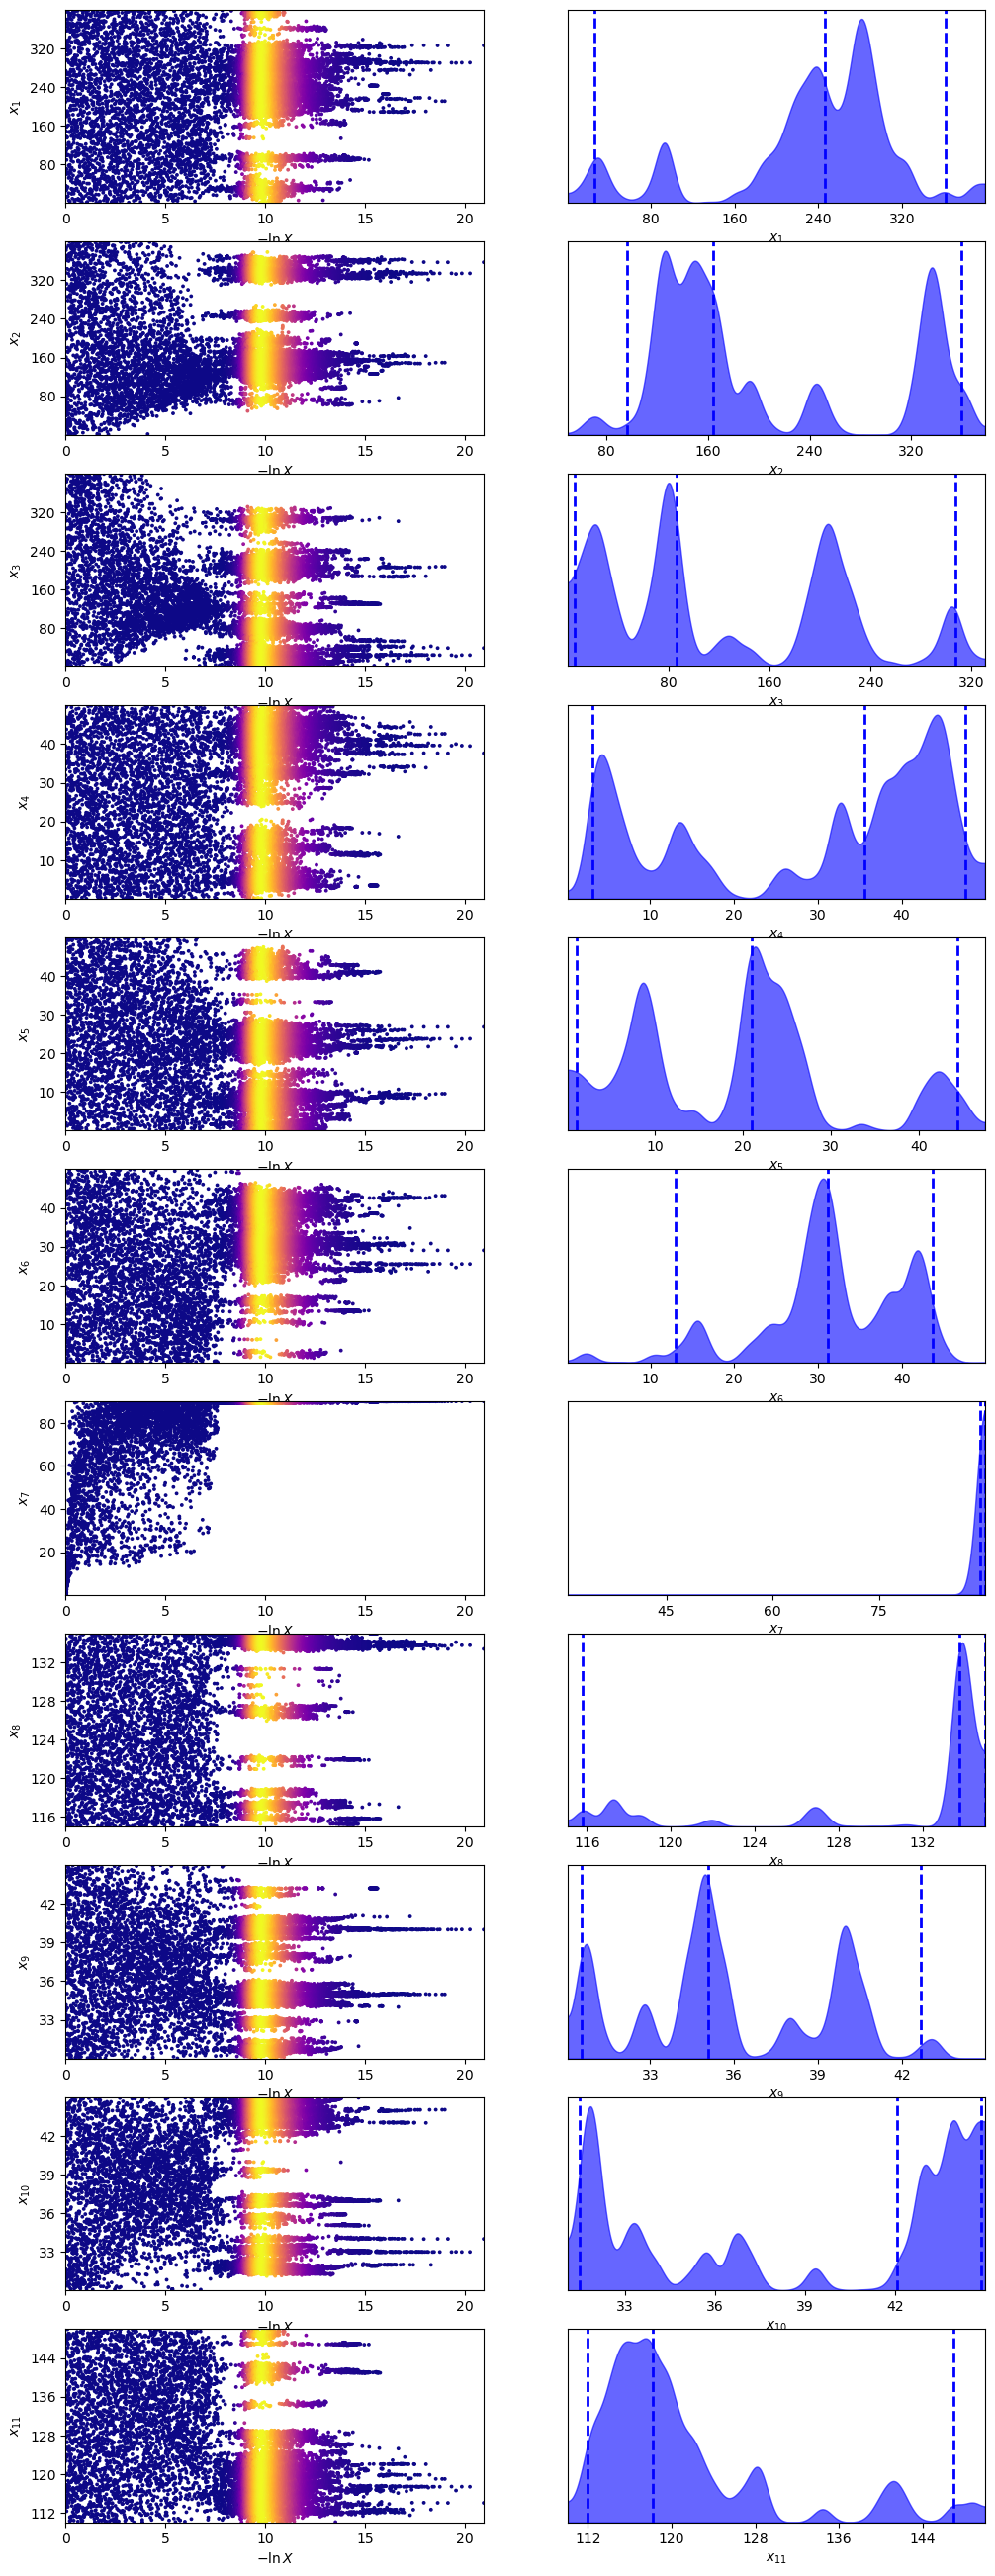

In [96]:
results = f3d.results
#print(results)

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)
rfig.savefig(outputfile+'output_run.pdf',bbox_inches='tight')

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)
tfig.savefig(outputfile+'posteriors.pdf',bbox_inches='tight')

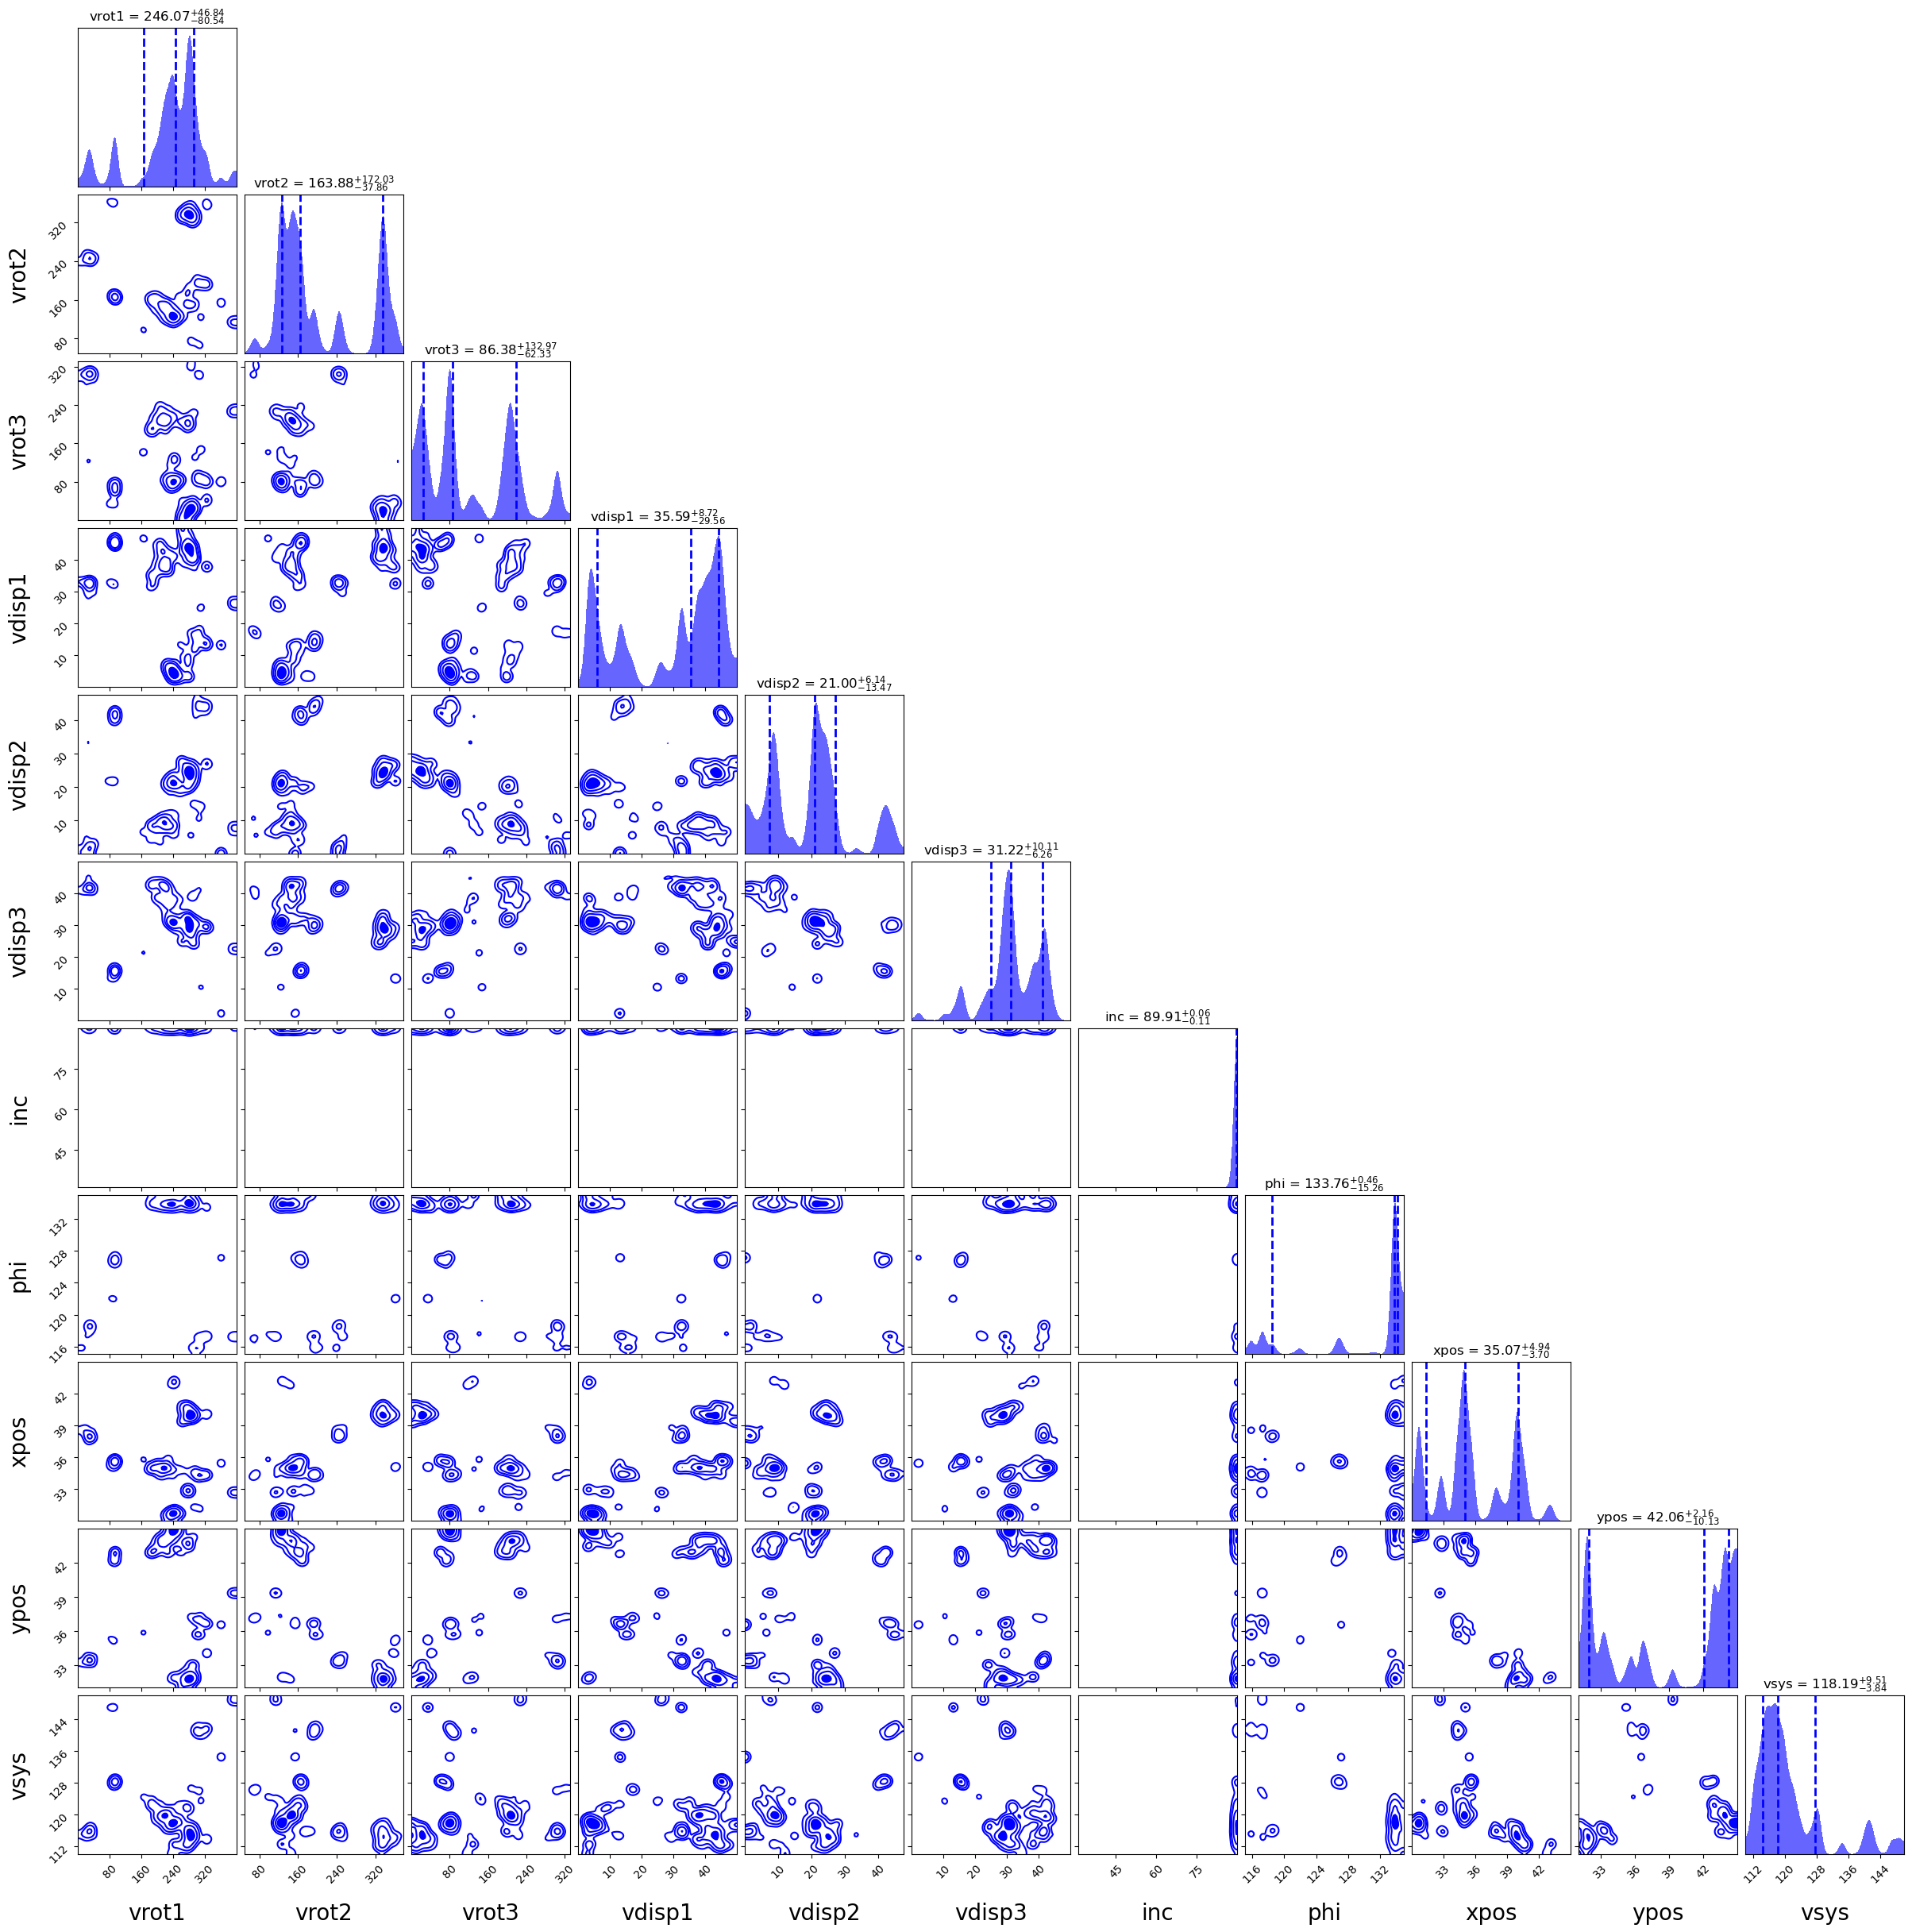

In [97]:
# Plot the 2-D marginalized posteriors.
quantiles = [0.16,0.50,0.84] # are these the contours?
cfig, caxes = dyplot.cornerplot(results,show_titles=True,title_quantiles=quantiles,
                                quantiles=quantiles, color='blue',max_n_ticks=5, labels=f3d.freepar_names, \
                                label_kwargs=dict(fontsize=20))
cfig.savefig(outputfile+'corner.pdf',bbox_inches='tight')

## Errors:

In [98]:
samples = f3d.results.samples #these are all the samples that dynesty got, the last array are the parameters
print(samples)
weights = np.exp(f3d.results.logwt - f3d.results.logz[-1])
print("logwtt",f3d.results.logwt,"logz",f3d.results.logz[-1])
params = np.average(samples, axis=0, weights=weights) #mean of values 

rad_mc = f3d._inri.r['radii']  # Get the radii array
labs = f3d.freepar_names

ra, pp, err_up, err_low = np.zeros(shape=(4, len(params)))
# Adjust how we index rad_mc for vrot and vdisp parameters, using modulo if needed
for i in range(len(params)):
    mcmc = np.percentile(samples[:, i], [15.865, 50, 84.135])
    print(mcmc)
    q = np.diff(mcmc)
    print("this is q",q)
    txt = "%10s = %10.3f %+10.3f %+10.3f" % (labs[i], mcmc[1], -q[0], q[1])
    
    pp[i] = mcmc[1]
    err_low[i] = q[0]
    err_up[i] = q[1]
    
    # For vrot and vdisp parameters, assign the radius values
    if labs[i].startswith("vrot") or labs[i].startswith("vdisp"):
        # Use modulo indexing to ensure we don't go out of bounds (repeat the radii if necessary)
        idx = i % len(rad_mc)  # Ensure the index is within bounds
        ra[i] = rad_mc[idx]
    else:
        ra[i] = None  # No radius for other parameters

output_file = "errors.txt"
with open(outputfile+output_file, "w") as file:
    file.write(f"#{'Parameter':<15}{'Median':<15}{'Error_Low':<15}{'Error_Up':<15}{'Radius':<15}\n")
    
    for i in range(len(params)):

        # Check if the parameter is vrot or vdisp and write the radius
        if labs[i].startswith("vrot") or labs[i].startswith("vdisp"):

            # If the radius is None, print 'N/A' for the radius
            radius_str = f"{ra[i]:<15.6f}" if ra[i] is not None else "N/A"
            file.write(f"{labs[i]:<15}{pp[i]:<15.6f}{err_low[i]:<15.6f}{err_up[i]:<15.6f}{radius_str}\n")
        else:
            # Write the parameters without radius (vsys, inc, pa, xpos, ypos, etc.)
            file.write(f"{labs[i]:<15}{pp[i]:<15.6f}{err_low[i]:<15.6f}{err_up[i]:<15.6f}{"N/A":<15}\n")

with open(outputfile+output_file, "r") as file:
    content = file.read()
print(content)

print(f"Results saved to {output_file}")


[[273.53670811  43.15500707 224.3470089  ...  37.25878529  31.38054948
  145.72081633]
 [ 12.55283589 127.50966343   9.37086502 ...  37.88187738  41.85630779
  127.58332864]
 [325.79025969 157.51668604 204.88861001 ...  33.65392568  37.49054983
  142.13529787]
 ...
 [290.18588899 334.17277296  24.48715441 ...  40.00642343  32.99437862
  117.38369873]
 [290.30642109 334.17177584  24.39313696 ...  40.00250442  32.99771632
  117.36545883]
 [325.88416232 357.14129104  39.07180064 ...  39.99381547  34.00598828
  114.02677038]]
logwtt [-78.62581601 -75.5492271  -74.77012813 ... -20.95333095 -20.95333094
 -20.95333093] logz -9.834629969159195
[ 95.93658405 242.31794309 296.75370939]
this is q [146.38135904  54.4357663 ]
[121.58194166 161.71623154 335.1323538 ]
this is q [ 40.13428988 173.41612226]
[ 28.44593903 117.5875434  224.95319395]
this is q [ 89.14160436 107.36565056]
[ 6.48461509 32.6092778  43.90003928]
this is q [26.12466271 11.29076148]
[ 7.75521779 21.36427377 34.2256323 ]
this is

## THIS CODE IS WHEN WE USE REAL DATA


#Compare with "real" input parameters, this is now comparing with the output of bbarolo (normal)

#ringfile = '/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/output/SGP38326/rings_final1.txt'
t = Table.read(ringfile,format='ascii')
print(t.colnames)


fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(11,16))
ax = np.ravel(ax)
for a in ax:
    a.set_xlabel("radius (arcsec)")
print(f3d._inri.r.keys())
rad_mc = f3d._inri.r['radii']
print(rad_mc)
idx = f3d.freepar_idx['vrot']
ax[0].plot(t['RAD(arcs)'],t['VROT(km/s)'],label='input')
ax[0].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]],label='recovered')
ax[0].set_ylabel("vrot (km/s)")
ax[0].legend(loc='lower right')

idx = f3d.freepar_idx['vdisp']
ax[1].plot(t['RAD(arcs)'],t['DISP(km/s)'])
ax[1].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]])
ax[1].set_ylabel("vdisp (km/s)")

#idx = f3d.freepar_idx['inc']
#ax[2].plot(t['RAD(arcs)'],t['INC(deg)'])
#ax[2].#axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[2].#axhline(pp[idx][0],ls='--',color='orange')
#ax[2].set_ylabel("inc (deg)")
#ax[2].set_ylim(t['INC(deg)'][0]-20,t['INC(deg)'][0]+20)

#idx = f3d.freepar_idx['phi']
#ax[3].plot(t['RAD(arcs)'],t['P.A.(deg)'])
#ax[3].#axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[3].#axhline(pp[idx][0],ls='--',color='orange')
#ax[3].set_ylabel("phi (deg)")
#ax[3].set_ylim(t['P.A.(deg)'][0]-10,t['P.A.(deg)'][0]+10)

#idx = f3d.freepar_idx['z0']
#ax[4].plot(t['RAD(arcs)'],t['Z0(arcs)'])
#ax[4].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[4].axhline(pp[idx][0],ls='--',color='orange')
#ax[4].set_ylabel("z0 (arcs)")
#ax[4].set_ylim(t['Z0(arcs)'][0]-30,t['Z0(arcs)'][0]+30)

idx = f3d.freepar_idx['vsys']
ax[5].plot(t['RAD(arcs)'],t['VSYS(km/s)'])
ax[5].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
ax[5].axhline(pp[idx][0],ls='--',color='orange')
ax[5].set_ylabel("vsys (km/s)")
ax[5].set_ylim(t['VSYS(km/s)'][0]-30,t['VSYS(km/s)'][0]+30)

#idx = f3d.freepar_idx['xpos']
#ax[6].plot(t['RAD(arcs)'],t['XPOS(pix)'])
#ax[6].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[6].axhline(pp[idx][0],ls='--',color='orange')
#ax[6].set_ylabel("xpos (pix)")
#ax[6].set_ylim(t['XPOS(pix)'][0]-5,t['XPOS(pix)'][0]+5)

#idx = f3d.freepar_idx['ypos']
#ax[7].plot(t['RAD(arcs)'],t['YPOS(pix)'])
#ax[7].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[7].axhline(pp[idx][0],ls='--',color='orange')
#ax[7].set_ylabel("ypos (pix)")
#ax[7].set_ylim(t['YPOS(pix)'][0]-5,t['YPOS(pix)'][0]+5)

fig.savefig(outputfile+'parameters.pdf',bbox_inches='tight')

## THIS CODE IS WHEN WE USE THE MODELS

[0 1 2]


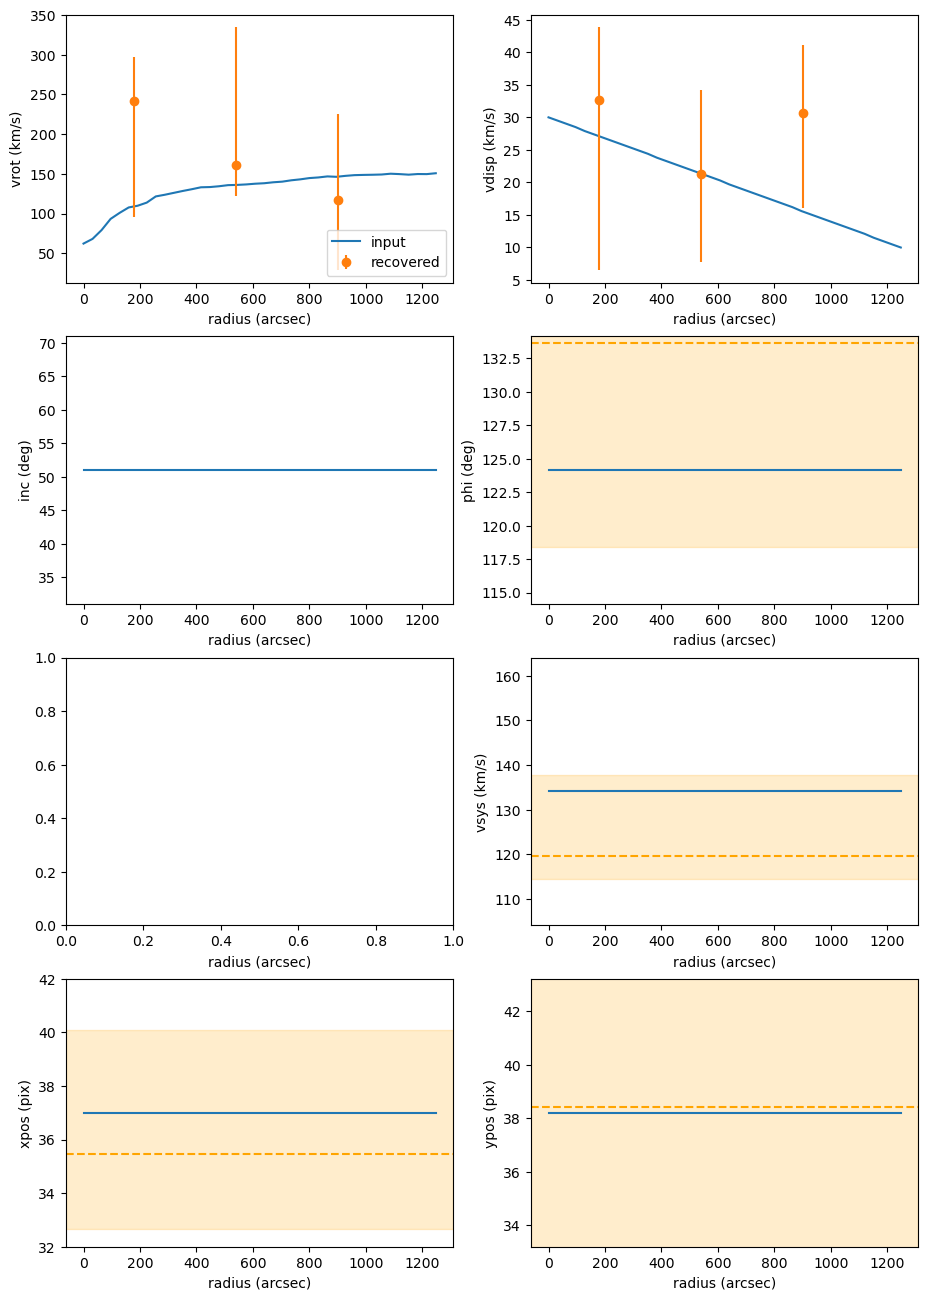

In [99]:

t = Table.read(ringfile,format='ascii')


fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(11,16))
ax = np.ravel(ax)
for a in ax:
    a.set_xlabel("radius (arcsec)")

rad_mc = f3d._inri.r['radii']

idx = f3d.freepar_idx['vrot']
print(idx)
ax[0].plot(t['RADII'],t['VROT'],label='input')
ax[0].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]],label='recovered')
ax[0].set_ylabel("vrot (km/s)")
ax[0].legend(loc='lower right')

idx = f3d.freepar_idx['vdisp']
ax[1].plot(t['RADII'],t['VDISP'])
ax[1].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]])
ax[1].set_ylabel("vdisp (km/s)")

if "inc" in f3d.freepar_idx:
    idx = f3d.freepar_idx['inc']
    ax[2].plot(t['RADII'],t['INC'])
    ax[2].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
    ax[2].axhline(pp[idx][0],ls='--',color='orange')
    ax[2].set_ylabel("inc (deg)")
    ax[2].set_ylim(t['INC'][0]-20,t['INC'][0]+20)

if "phi" in f3d.freepar_idx:
    idx = f3d.freepar_idx['phi']
    ax[3].plot(t['RADII'],t['PA'])
    ax[3].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
    ax[3].axhline(pp[idx][0],ls='--',color='orange')
    ax[3].set_ylabel("phi (deg)")
    ax[3].set_ylim(t['PA'][0]-10,t['PA'][0]+10)

#idx = f3d.freepar_idx['z0']
#ax[4].plot(t['RADII'],t['Z0'])
#ax[4].#axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
#ax[4].#axhline(pp[idx][0],ls='--',color='orange')
#ax[4].set_ylabel("z0 (arcs)")
#ax[4].set_ylim(t['Z0'][0]-30,t['Z0'][0]+30)

idx = f3d.freepar_idx['vsys']
ax[5].plot(t['RADII'],t['VSYS'])
ax[5].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
ax[5].axhline(pp[idx][0],ls='--',color='orange')
ax[5].set_ylabel("vsys (km/s)")
ax[5].set_ylim(t['VSYS'][0]-30,t['VSYS'][0]+30)

if "xpos" in f3d.freepar_idx:
    idx = f3d.freepar_idx['xpos']
    ax[6].plot(t['RADII'],t['XPOS'])
    ax[6].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
    ax[6].axhline(pp[idx][0],ls='--',color='orange')
    ax[6].set_ylabel("xpos (pix)")
    ax[6].set_ylim(t['XPOS'][0]-5,t['XPOS'][0]+5)

if "ypos" in f3d.freepar_idx:
    idx = f3d.freepar_idx['ypos']
    ax[7].plot(t['RADII'],t['YPOS'])
    ax[7].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
    ax[7].axhline(pp[idx][0],ls='--',color='orange')
    ax[7].set_ylabel("ypos (pix)")
    ax[7].set_ylim(t['YPOS'][0]-5,t['YPOS'][0]+5)

fig.savefig(outputfile+'parameters.pdf',bbox_inches='tight')

In [100]:
# If one wants to change the likelihood and/or prior, can just write a class that inherits
# from BayesianBBarolo and redefine the log_likelihood and prior_transform functions

class CustomBayesianBBarolo(BayesianBBarolo):
    def log_likelihood(self, theta):
        ...

    def prior_transform(self, u):
        ...

custom_f3d = CustomBayesianBBarolo(fitsname)


HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /Users/blanca/Documents/TESIS/software/code/models/model3.fits
Reading 75 x 75 x 62 pixels FITS file (1.3 MB)... Done. 



In [101]:
#inp = FitsCube(fitsname)
#mod = libBB.Galfit_new_par(inp._cube,inri._rings,opts._params)

# SOME THINGS TO DO 

- Fix parallel execution
- Play with dynesty samplers and parameters (these can be passed to compute() by dynesty_kwargs)
- Decide if residuals are calculated by BB or in python (more flexible)
- Need to implement output model generation + usual plots (various maps, pvs, etc...)
- Easily expandable to fit also other parameters (DENS, VVERT, DVDZ, ZCYL)
- Easily expandable to support functional forms for parameters
- There is a memory leak somewhere, memory usage grows when it should not (not a big problem though).